In [2]:
from cobra.io import read_sbml_model, validate_sbml_model
from os import listdir
import scipy.stats
import pandas as pd

path = '../models/ga_models/Recon3D_LT15_trimed_corda_model_8_60_95.xml'



In [3]:
import json
import pandas as pd

#Read experimental data
exp_data = '../data/raw/experimental_data/GSE56496_ensembl.tsv'

df = pd.read_csv(exp_data, sep='\t')
arr = df['ensembl'].values
#Make requests to ensembl to get all ensembl ID converted into gene ID (or gene names)

df.index = arr
df.pop('ensembl')
df

,GSM1362700,GSM1362701,GSM1362702,GSM1362703,GSM1362704,GSM1362705,GSM1362706,GSM1362707
ENSG00000000003,15.018898,14.884603,14.026153,13.469870,15.133000,14.754934,13.901318,13.416486
ENSG00000000005,2.284015,2.332738,2.174118,2.243632,2.228597,2.968391,2.292607,2.657296
ENSG00000000419,17.538248,17.681952,17.592800,17.601034,17.346663,17.689093,17.704203,17.524693
ENSG00000000457,12.571251,12.570168,13.475803,13.076996,12.123830,12.386517,13.654110,12.723597
ENSG00000000460,14.718670,14.836032,15.531955,13.763633,14.726372,14.851385,15.319104,13.432143
...,...,...,...,...,...,...,...,...
ENSG00000286169,14.082297,12.316029,12.145751,11.659980,14.160425,12.529424,12.248211,11.368181
ENSG00000286190,4.741332,5.313175,9.186693,10.023605,4.624242,5.350209,9.022822,9.544429
ENSG00000286522,13.961711,14.064487,14.761260,16.216487,14.063406,13.877782,15.000317,16.485493
ENSG00000287080,16.552356,16.326415,16.548528,16.903916,16.724889,16.419580,16.630865,16.906341


In [4]:
import json, requests
gene_dict = {}
arr = df.index
for e in arr:
    API_ENDPOINT = 'http://rest.ensembl.org/lookup/id/'+e+'?content-type=application/json'

    r = requests.get(url = API_ENDPOINT)

    response = r.json()
    #print(response)
    if 'display_name' in response.keys():
        gene_dict[e] = response['display_name']
    #print(gene_dict)
gene_dict
with open('../data/processed/ensembl_genes.json', 'w') as fp:
    json.dump(gene_dict, fp)

KeyboardInterrupt: 

In [26]:
df.index

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000285756', 'ENSG00000285793', 'ENSG00000285967',
       'ENSG00000286042', 'ENSG00000286058', 'ENSG00000286169',
       'ENSG00000286190', 'ENSG00000286522', 'ENSG00000287080',
       'ENSG00000287263'],
      dtype='object', length=17460)

In [10]:
df = df.rename(gene_dict, axis=0)
df.head()

,GSM1362700,GSM1362701,GSM1362702,GSM1362703,GSM1362704,GSM1362705,GSM1362706,GSM1362707
TSPAN6,15.018898,14.884603,14.026153,13.469870,15.133000,14.754934,13.901318,13.416486
TNMD,2.284015,2.332738,2.174118,2.243632,2.228597,2.968391,2.292607,2.657296
DPM1,17.538248,17.681952,17.592800,17.601034,17.346663,17.689093,17.704203,17.524693
SCYL3,12.571251,12.570168,13.475803,13.076996,12.123830,12.386517,13.654110,12.723597
C1orf112,14.718670,14.836032,15.531955,13.763633,14.726372,14.851385,15.319104,13.432143


In [12]:
df.to_parquet('../data/processed/GSE56496_geneid.parquet')

In [2]:
import pandas as pd
df = pd.read_parquet('../data/processed/GSE56496_geneid.parquet')

In [3]:
df = df.rename(columns={'GSM1362700':'control1', 'GSM1362701':'30ug_1', 'GSM1362702':'60ug_1', 'GSM1362703':'100ug_1', 'GSM1362704':'control2', 'GSM1362705':'30ug_2', 'GSM1362706':'60ug_2', 'GSM1362707':'100ug_2'})

In [6]:
import pandas as pd
import cobra
from cobra.io import read_sbml_model

sbml_fname = '../models/Recon3DModel_301_no_isoforms_gene_symbols_rpmi_trimed.xml'

# Read the model
model = read_sbml_model(sbml_fname)
model.solver = 'glpk'
model.objective = "biomass_reaction"
model_genes = [g.id for g in model.genes]

Restricted license - for non-production use only - expires 2022-01-13


In [7]:
df['control_mean'] = (df['control1']+df['control2']) / 2

In [8]:
df = df.loc[df.index.intersection(model_genes)]

In [9]:
df

,control1,30ug_1,60ug_1,100ug_1,control2,30ug_2,60ug_2,100ug_2,control_mean
FUCA2,15.243344,14.958344,15.067353,14.878490,15.201268,15.039507,14.868065,15.080322,15.222306
GCLC,14.654244,15.260847,14.203550,13.828453,14.405624,14.992152,14.384733,13.910562,14.529934
CFTR,5.025411,4.195718,4.391420,6.882344,5.339136,4.798545,4.223651,6.303617,5.182274
CYP51A1,14.446666,14.753008,14.210131,13.384712,14.214672,14.674433,14.344952,13.191619,14.330669
LAP3,15.513772,15.470570,14.933932,15.266427,15.654810,15.618998,14.850768,15.232822,15.584291
...,...,...,...,...,...,...,...,...,...
PNLIPRP2,13.092280,13.205764,11.545786,10.999715,13.074678,13.092030,11.535295,10.544248,13.083479
NDUFA7,16.645611,16.635909,16.253898,15.959967,16.659965,16.677221,16.334349,15.867120,16.652788
SLC6A14,3.602655,2.399760,2.864731,3.695132,4.129524,3.062537,2.293290,2.994946,3.866089
KMT2B,12.932358,12.891082,13.231962,13.336320,13.053846,13.027492,13.210378,13.378720,12.993102


In [10]:
experimental_genes = df.index

In [11]:
expression_stats_df = pd.read_parquet('../data/processed/expression_stats_df.parquet')
expression_stats_df

,mean_expression,median_expression,q10_expr,q25_expr,q50_expr,q75_expr,q90_expr,min,max
FUCA2,5.112298,5.646593,2.323208,4.696828,5.646593,6.246928,6.709842,0.000000,8.605702
GCLC,4.653770,4.528571,3.350494,3.922673,4.528571,5.305332,6.125775,1.163499,9.597587
CFTR,0.540902,0.084064,0.000000,0.014355,0.084064,0.367371,1.469877,0.000000,8.235775
CYP51A1,5.413314,5.487517,4.169923,4.888499,5.487517,6.071462,6.612279,0.000000,8.750640
LAP3,5.642403,5.675957,4.721364,5.238978,5.675957,6.127633,6.543571,1.655352,8.446049
...,...,...,...,...,...,...,...,...,...
KMT2B,4.243515,4.258142,3.330558,3.786595,4.258142,4.750070,5.095711,1.316146,6.699885
PIP4K2B,4.452039,4.498249,3.473785,4.008092,4.498249,4.922792,5.300307,0.748461,8.023865
PIGW,3.909415,3.976364,2.897239,3.416840,3.976364,4.433961,4.882398,0.807355,6.582556
SRD5A2,0.023346,0.014355,0.000000,0.000000,0.014355,0.028569,0.042644,0.000000,1.584963


In [12]:
expression_stats_df = expression_stats_df.loc[expression_stats_df.index.intersection(experimental_genes)]

In [13]:
expression_stats_df

,mean_expression,median_expression,q10_expr,q25_expr,q50_expr,q75_expr,q90_expr,min,max
FUCA2,5.112298,5.646593,2.323208,4.696828,5.646593,6.246928,6.709842,0.000000,8.605702
GCLC,4.653770,4.528571,3.350494,3.922673,4.528571,5.305332,6.125775,1.163499,9.597587
CFTR,0.540902,0.084064,0.000000,0.014355,0.084064,0.367371,1.469877,0.000000,8.235775
CYP51A1,5.413314,5.487517,4.169923,4.888499,5.487517,6.071462,6.612279,0.000000,8.750640
LAP3,5.642403,5.675957,4.721364,5.238978,5.675957,6.127633,6.543571,1.655352,8.446049
...,...,...,...,...,...,...,...,...,...
THTPA,3.279839,3.354731,2.196900,2.749533,3.354731,3.842225,4.275752,0.070389,6.218781
NDUFA7,6.449905,6.454093,5.641257,6.025526,6.454093,6.885971,7.212326,3.947666,8.570691
SLC6A14,0.437970,0.014355,0.000000,0.000000,0.014355,0.176323,1.277982,0.000000,7.005175
KMT2B,4.243515,4.258142,3.330558,3.786595,4.258142,4.750070,5.095711,1.316146,6.699885


In [14]:
common_genes = list(set(expression_stats_df.index) & set(df.index))

In [15]:
df = df.loc[df.index.intersection(common_genes)]
df

,control1,30ug_1,60ug_1,100ug_1,control2,30ug_2,60ug_2,100ug_2,control_mean
FUCA2,15.243344,14.958344,15.067353,14.878490,15.201268,15.039507,14.868065,15.080322,15.222306
GCLC,14.654244,15.260847,14.203550,13.828453,14.405624,14.992152,14.384733,13.910562,14.529934
CFTR,5.025411,4.195718,4.391420,6.882344,5.339136,4.798545,4.223651,6.303617,5.182274
CYP51A1,14.446666,14.753008,14.210131,13.384712,14.214672,14.674433,14.344952,13.191619,14.330669
LAP3,15.513772,15.470570,14.933932,15.266427,15.654810,15.618998,14.850768,15.232822,15.584291
...,...,...,...,...,...,...,...,...,...
THTPA,12.653446,12.456785,12.390850,11.789743,12.485138,12.308504,12.409501,11.860391,12.569292
NDUFA7,16.645611,16.635909,16.253898,15.959967,16.659965,16.677221,16.334349,15.867120,16.652788
SLC6A14,3.602655,2.399760,2.864731,3.695132,4.129524,3.062537,2.293290,2.994946,3.866089
KMT2B,12.932358,12.891082,13.231962,13.336320,13.053846,13.027492,13.210378,13.378720,12.993102


In [16]:
experimental_expression_dict = df['control_mean'].to_dict()

In [17]:
data_expression_dict = expression_stats_df['mean_expression'].to_dict()

In [18]:
x = []
y = []
for key in experimental_expression_dict:
    y.append(float(experimental_expression_dict[key]))
    x.append(float(data_expression_dict[key]))

r-squared: 0.634230462090141
p-value: 0.0


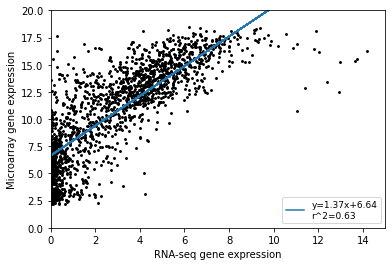

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
#plt.plot(x, y, 'o')

m, b, r_value, p_value, std_err = stats.linregress(x,y)
#m, b = np.polyfit(x, y, 1)
mx = [m*a for a in x]
plt.plot(x, mx + b, label ='y={:.2f}x+{:.2f}\nr^2={:.2f}'.format(m,b,r_value**2))
plt.scatter(x,y, color="k", s=3.5)
plt.legend(loc='lower right',fontsize=9)

plt.xlim(0, 15)
plt.ylim(0, 20)
plt.ylabel('Microarray gene expression')
plt.xlabel('RNA-seq gene expression')

print("r-squared:", r_value**2)
print("p-value:",p_value)
#line = mx+intercept
#plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

Una vez tenemos los parámetros a=1.37 y b=6.64; podemos inferir los percentiles de los datos del CCLE al espacio de los arrays

In [18]:
expression_stats_df

,mean_expression,median_expression,q10_expr,q25_expr,q50_expr,q75_expr,q90_expr,min,max
FUCA2,5.112298,5.646593,2.323208,4.696828,5.646593,6.246928,6.709842,0.000000,8.605702
GCLC,4.653770,4.528571,3.350494,3.922673,4.528571,5.305332,6.125775,1.163499,9.597587
CFTR,0.540902,0.084064,0.000000,0.014355,0.084064,0.367371,1.469877,0.000000,8.235775
CYP51A1,5.413314,5.487517,4.169923,4.888499,5.487517,6.071462,6.612279,0.000000,8.750640
LAP3,5.642403,5.675957,4.721364,5.238978,5.675957,6.127633,6.543571,1.655352,8.446049
...,...,...,...,...,...,...,...,...,...
THTPA,3.279839,3.354731,2.196900,2.749533,3.354731,3.842225,4.275752,0.070389,6.218781
NDUFA7,6.449905,6.454093,5.641257,6.025526,6.454093,6.885971,7.212326,3.947666,8.570691
SLC6A14,0.437970,0.014355,0.000000,0.000000,0.014355,0.176323,1.277982,0.000000,7.005175
KMT2B,4.243515,4.258142,3.330558,3.786595,4.258142,4.750070,5.095711,1.316146,6.699885


In [21]:
df_expression = pd.read_parquet('../data/processed/CCLE_expression_processed.parquet')
df_expression

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
LC1SQSF_LUNG,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,5.053980,...,1.214125,0.000000,0.111031,0.150560,1.427606,5.781884,0.000000,0.000000,0.799087,0.000000
COGAR359_SOFT_TISSUE,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,3.832890,...,1.835924,0.000000,0.310340,0.000000,0.807355,4.704319,0.000000,0.000000,0.464668,0.070389
COLO794_SKIN,3.779260,0.000000,7.346425,2.339137,4.254745,0.056584,1.339137,6.724241,3.671293,3.775051,...,1.823749,0.084064,0.176323,0.042644,1.384050,4.931683,0.000000,0.028569,0.263034,0.000000
KKU213_BILIARY_TRACT,5.726831,0.000000,7.086189,2.543496,3.102658,0.000000,5.914565,6.099716,4.475733,4.294253,...,0.871844,0.137504,0.263034,2.485427,0.713696,3.858976,0.000000,0.000000,0.000000,0.000000
RT4_URINARY_TRACT,7.465648,0.000000,6.435462,2.414136,3.864929,0.831877,7.198003,5.452530,7.112492,4.710944,...,2.324811,0.163499,0.163499,0.000000,1.117695,4.990501,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOXIMVI_SKIN,4.173127,0.000000,6.400879,1.807355,3.303050,0.014355,0.137504,4.944858,4.528571,4.383359,...,1.280956,0.176323,0.084064,0.000000,2.615887,5.102658,0.000000,0.097611,0.214125,0.000000
TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.097611,0.000000,6.428276,3.257011,4.980482,0.411426,0.124328,0.704872,4.829342,5.393348,...,2.939227,0.000000,0.014355,0.000000,3.326250,6.341630,0.000000,0.000000,0.310340,0.000000
SSP25_BILIARY_TRACT,5.045268,0.000000,6.991749,1.807355,3.270529,0.028569,3.333424,6.819796,5.395063,3.727920,...,1.510962,0.056584,0.097611,0.286881,1.925999,4.607626,0.111031,0.000000,1.090853,0.000000
ECC2_BILIARY_TRACT,5.805292,0.000000,7.792855,2.482848,3.903038,0.028569,4.124328,6.816600,4.458119,3.664483,...,0.757023,0.150560,0.432959,0.111031,0.613532,4.787119,0.000000,0.163499,0.084064,0.000000


In [22]:
aux_df = pd.DataFrame()
aux_df['p8'] = df_expression.quantile(8/100)
aux_df['p60'] = df_expression.quantile(60/100)
aux_df['p95'] = df_expression.quantile(95/100)
aux_df = aux_df.fillna(0)
aux_df

,p8,p60,p95
TSPAN6,0.111031,4.710393,5.988929
TNMD,0.000000,0.000000,0.292746
DPM1,5.519164,6.548128,7.407073
SCYL3,1.650765,2.454176,3.303415
C1orf112,2.531069,3.909773,4.879450
...,...,...,...
POLR2J3,3.447579,5.477354,6.659461
H2BE1,0.000000,0.000000,0.201634
AL445238.1,0.000000,0.000000,0.214125
GET1-SH3BGR,0.000000,0.575312,1.435621


In [25]:
aux_df = aux_df.apply(lambda x: x*m + b)

In [26]:
aux_df

,p8,p60,p95
TSPAN6,6.791540,13.095410,14.847767
TNMD,6.639361,6.639361,7.040597
DPM1,14.203909,15.614203,16.791469
SCYL3,8.901893,10.003046,11.167011
C1orf112,10.108436,11.998082,13.327119
...,...,...,...
POLR2J3,11.364601,14.146603,15.766795
H2BE1,6.639361,6.639361,6.915719
AL445238.1,6.639361,6.639361,6.932839
GET1-SH3BGR,6.639361,7.427882,8.607018


In [ ]:
gene_dict = df.to_dict()['control_mean']
gene_dict

In [31]:
def gene_confidence(gene_dict, curr_df):
    gene_confidence_dict = {}
    confidence_zero_genes = set(model_genes) - set(gene_dict.keys())
    
    for gene in confidence_zero_genes:
        gene_confidence_dict[gene] = 0
        
    for k,v in gene_dict.items():
        gene_expr_stats_df = curr_df.loc[k]
        q_1 = gene_expr_stats_df['p8']
        q_2 = gene_expr_stats_df['p60']
        q_4 = gene_expr_stats_df['p95']
        if not v == 'nan':
            if v <= q_1:
                gene_confidence_dict[k] = -1
            elif v <= q_2:
                gene_confidence_dict[k] = 1
            elif v < q_4:
                gene_confidence_dict[k] = 2
            elif v >= q_4:
                gene_confidence_dict[k] = 3
        else:
            #If 'nan' then assign confidence == 0
            gene_confidence_dict[k] = 0
    
    return gene_confidence_dict

In [33]:
gene_confidence_dict = gene_confidence(gene_dict, aux_df)

In [38]:
import re
from corda import reaction_confidence
def create_rxn_confidence(gene_confidence_dict):
    rxn_conf_dict = {}
    for r in model.reactions:
        if re.match('biomass_reaction', r.id):
            rxn_conf_dict[r.id] = 3
        else:
            if len(r.genes) > 0:
                gpr = r.gene_reaction_rule
                rxn_conf_dict[r.id] =  reaction_confidence(gpr, gene_confidence_dict)
            else:
                rxn_conf_dict[r.id] =  0
    return rxn_conf_dict

In [39]:
rxn_conf_dict = create_rxn_confidence(gene_confidence_dict)

In [48]:
from corda import CORDA
print('Building corda model:', end=' ')
opt = CORDA(model, rxn_conf_dict)
opt.build()
print(opt)
print('OK')
model_cs = opt.cobra_model("model_build")
model_cs.objective = "biomass_reaction"

Building corda model: build status: reconstruction complete
Inc. reactions: 3721/8951
 - unclear: 1329/3825
 - exclude: 111/1074
 - low and medium: 872/2643
 - high: 1409/1409

OK


C:\Miniconda3\lib\site-packages\cobra\core\group.py:107: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [49]:
cobra.io.write_sbml_model(model_cs, '../data/processed/experimental_control_cs_model.xml')

In [3]:
from cobra.io import read_sbml_model

model = read_sbml_model('../data/processed/experimental_control_cs_model.xml')

Restricted license - for non-production use only - expires 2022-01-13


In [4]:
model.solver = 'glpk'
solution = model.optimize()
objective_value = solution.objective_value

In [5]:
# Import the function single_gene_deletion
from cobra.flux_analysis import single_gene_deletion

# Then get the list of all the genes
all_genes = [g.id for g in model.genes]

# Running in silico (takes a while)
knockout = single_gene_deletion(model, gene_list=all_genes)

# This is a fix to get the gene's id as the index
knockout['ids'] = [list(i)[0] for i in knockout.ids]
knockout = knockout.set_index('ids')

# The output of the function single_gene_deletion is a dataframe
knockout.head()

,growth,status
ids,,
GUCY1B3,0.05306,optimal
TPSB2,0.05306,optimal
LOC344967,0.05306,optimal
EXT2,0.05306,optimal
HMGCL,0.05306,optimal


In [7]:
# We define a threshold to define whether the reduction on the biomass flux is considered lethal.
objective_value = solution.objective_value
threshold = objective_value*0.01

# Use this threshold to find which set of genes' knock out reduce the predicted growth below the threshold.
insilico_lethals = set(knockout.index[knockout.growth< threshold])
# The set of non-essential genes are the genes with a growth value above the threshold.
insilico_non_lethals = set(knockout.index[knockout.growth > threshold])

print("in-silico lethals:", len(insilico_lethals))
print("in-silico non lethals:", len(insilico_non_lethals))

in-silico lethals: 40
in-silico non lethals: 1399


In [10]:
import pandas as pd
ceres_stats_df = pd.read_parquet('../data/processed/ceres_stats_df.parquet')
lethal_ceres_df = ceres_stats_df.loc[ceres_stats_df.index.intersection(insilico_lethals)]
non_lethal_ceres_df = ceres_stats_df.loc[ceres_stats_df.index.intersection(insilico_non_lethals)]

C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` 

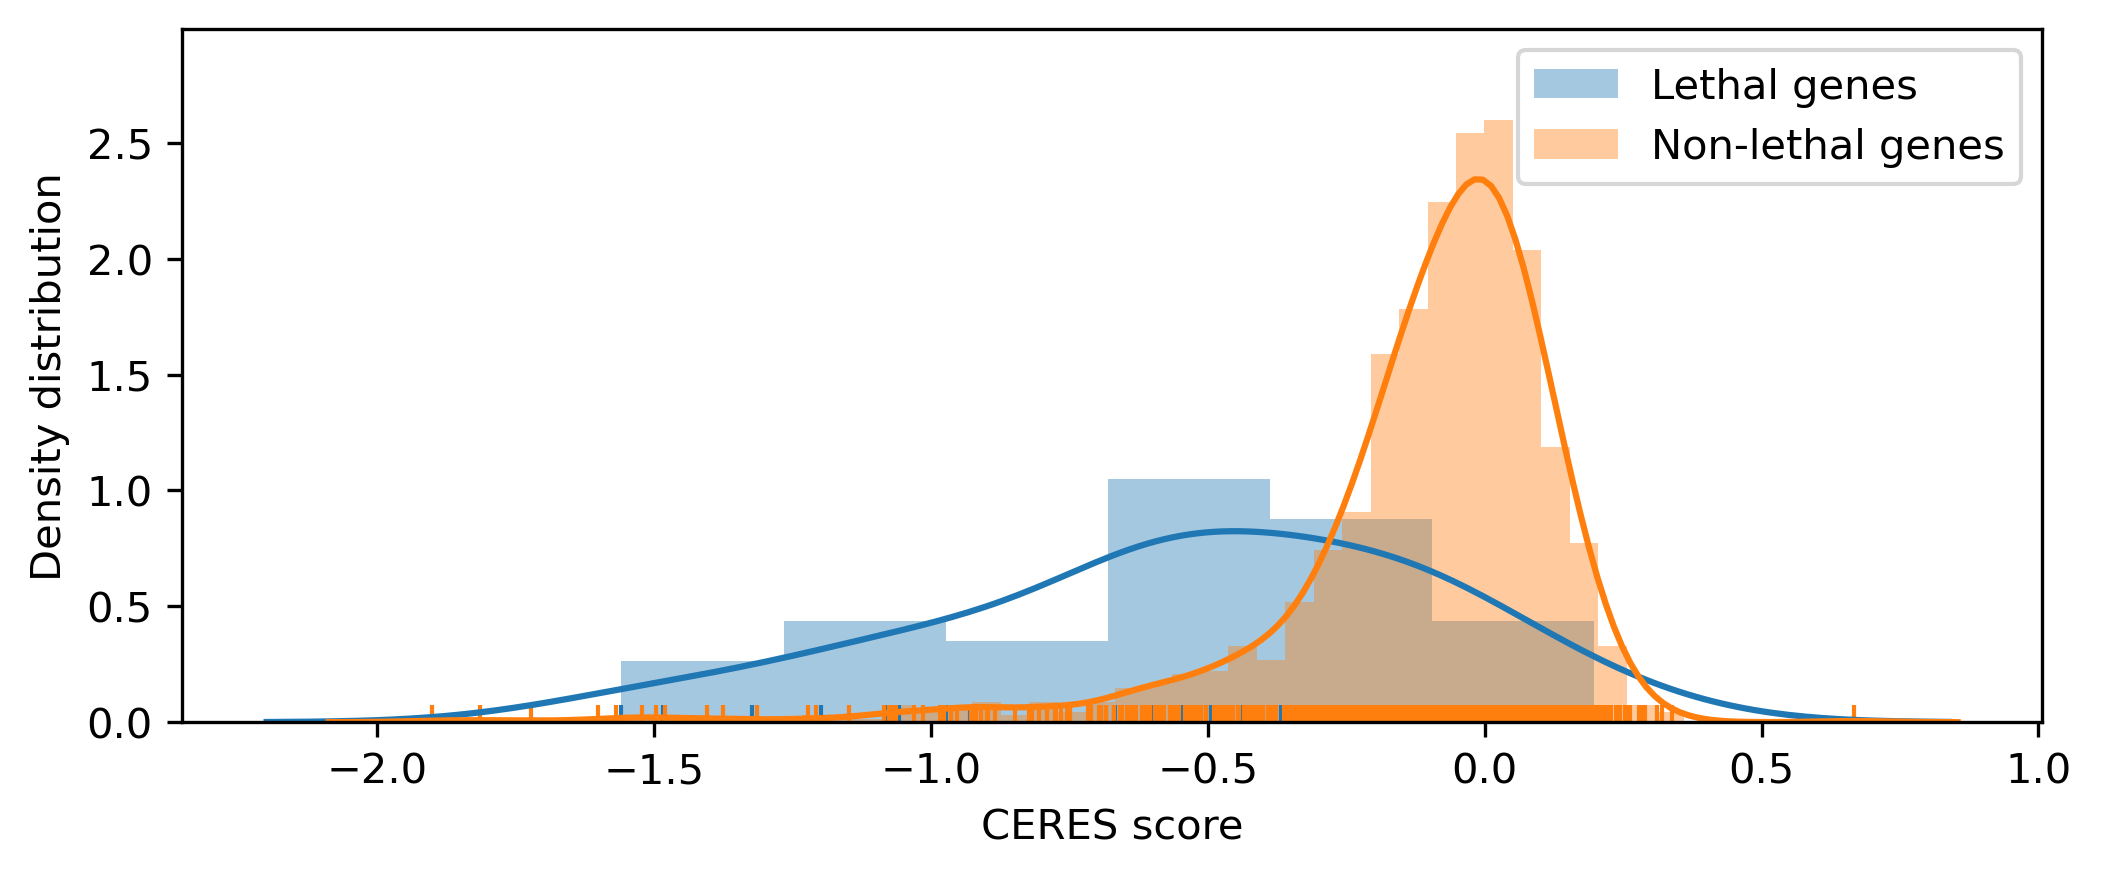

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)

sns.distplot(lethal_ceres_df['mean_ceres'], ax=ax, rug=True, kde=True, label='Lethal genes')
sns.distplot(non_lethal_ceres_df['mean_ceres'], ax=ax, rug=True, kde=True, label='Non-lethal genes')

ax.set_xlabel("CERES score")
ax.set_ylabel("Density distribution")
ax.legend()
fig

In [12]:
import scipy.stats
scipy.stats.mannwhitneyu(lethal_ceres_df['mean_ceres'],non_lethal_ceres_df['mean_ceres'])

MannwhitneyuResult(statistic=9413.0, pvalue=8.559849390995323e-12)

In [13]:
lethal_ceres_df

,mean_ceres,median_ceres,q10_ceres,q25_ceres,q50_ceres,q75_ceres,q90_ceres,min,max
ADSL,-1.058650,-1.051760,-1.580191,-1.362997,-1.051760,-0.752233,-0.538095,-2.214390,-0.019661
ATIC,-0.494136,-0.456109,-0.922936,-0.709735,-0.456109,-0.279249,-0.132209,-1.492050,0.199596
CAD,-0.368502,-0.317427,-0.821769,-0.567498,-0.317427,-0.132112,-0.009303,-1.577007,0.317084
CMPK1,-0.929606,-0.944503,-1.150137,-1.057911,-0.944503,-0.813142,-0.663796,-1.921615,0.059529
CPT2,-0.228518,-0.222341,-0.392078,-0.297872,-0.222341,-0.149824,-0.077659,-0.911759,0.268453
CRLS1,-0.752807,-0.756283,-1.036477,-0.901713,-0.756283,-0.608914,-0.459867,-1.504024,-0.134819
DHFR,-0.683173,-0.672340,-1.086844,-0.905304,-0.672340,-0.450057,-0.287784,-1.637133,0.453078
DHODH,-0.595909,-0.552897,-0.953939,-0.742221,-0.552897,-0.419603,-0.304771,-1.520637,-0.015971
DTYMK,-1.559395,-1.599233,-1.973525,-1.790539,-1.599233,-1.401412,-1.062742,-2.597602,-0.331860
EBP,-0.008359,-0.003852,-0.149033,-0.079424,-0.003852,0.064511,0.125417,-0.551766,0.463220
